# Transfer Learning with Pytorch

Transfer learning is a machine learning technique where a pre-trained model, which has been trained on a large dataset for a specific task, is repurposed as the starting point for training a new model on a different but related task.

Transfer learning offers several advantages:
- **Faster Training**
- **Better Performance**
- **Feature Extraction**
- **Domain Adaptation**

PyTorch is a popular deep learning framework that is well-suited for transfer learning, and here's why you might choose to use PyTorch for this purpose:
- **Dynamic Computation Graph**
- **Large Pre-trained Model Collection**
- **Flexible and Intuitive API**
- **Active Research Community**

In summary, transfer learning is a powerful technique for leveraging pre-trained models to solve new tasks, and PyTorch's dynamic nature, pre-trained model collection, and ease of use make it a suitable choice for implementing transfer learning workflows.

## About Dataset

**Food Image Classification Dataset**
- The dataset contains **19K** unique images obtained from various Google resources
- Focuses on **17 varieties** of Western appetizers
- Meticulously curated images ensuring diversity and representativeness
- Provides a solid foundation for developing robust and precise image classification algorithms
- Encourages exploration in the fascinating field of food image classification

## Import Library

In [16]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import os
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

## Load Data

In [3]:
INPUT_PATH = 'data'
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
VALIDATION_PATH = 'data/val'
CLASS_NAMES = os.listdir('data/train')
CLASS_NAMES.sort()

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize])

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_PATH, train_transforms),
    'validation': datasets.ImageFolder(VALIDATION_PATH, test_transforms),
    'test' : datasets.ImageFolder(TEST_PATH, test_transforms)
}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64,shuffle=False)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64,shuffle=False)

## Inspect Data

### Data Count

In [5]:
# Train Count
print("Data Count")
print("----------")
print(f"Training total   : {len(train_loader.dataset)}")
print(f"Validation total : {len(val_loader.dataset)}")
print(f"Testing total    : {len(test_loader.dataset)}")

Data Count
----------
Training total   : 15202
Validation total : 1899
Testing total    : 1903


### Images Preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


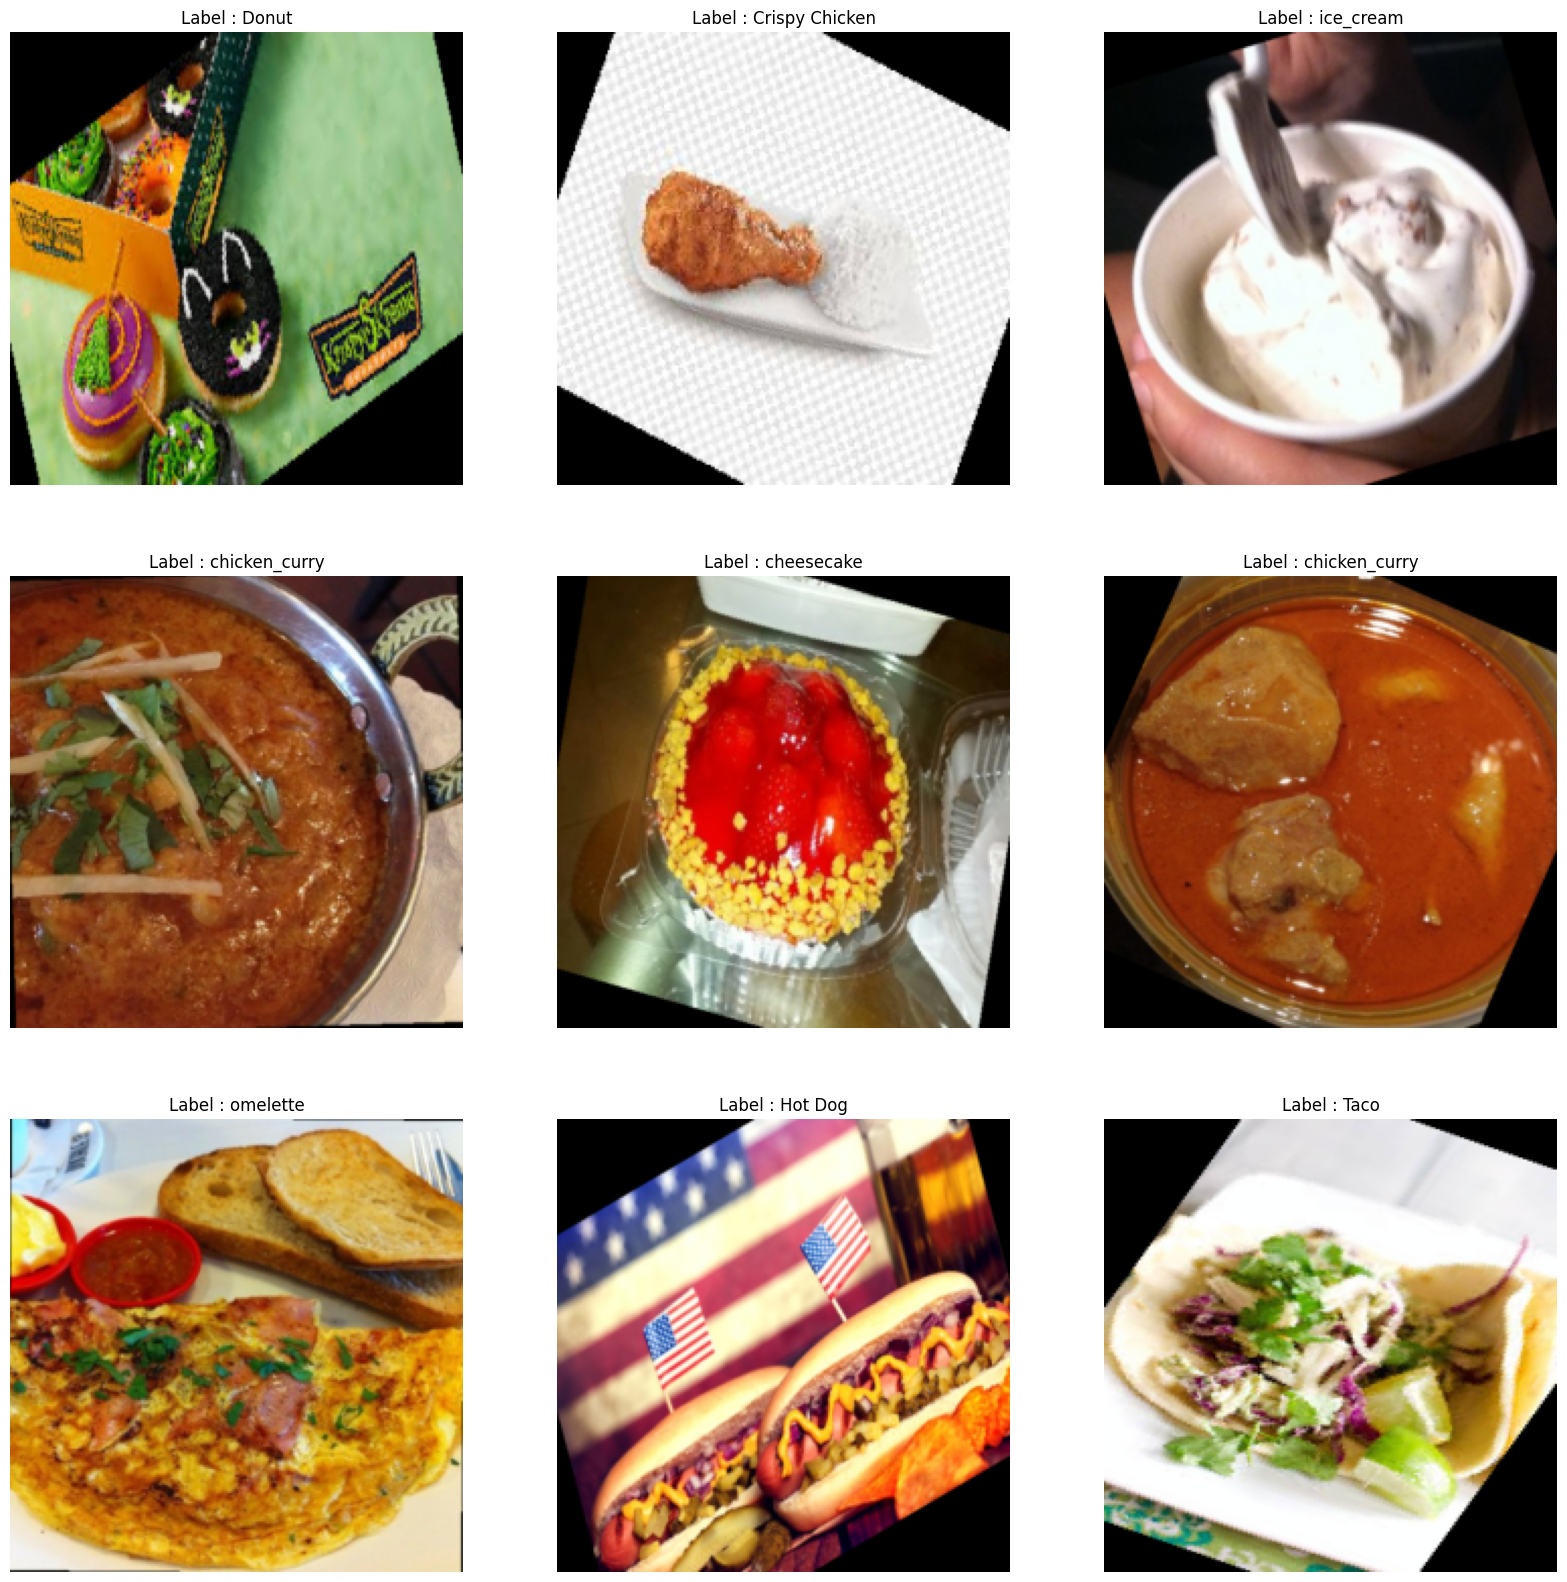

In [6]:
img, label = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].permute(1, 2, 0).numpy() * std + mean)
    plt.title(f'Label : {CLASS_NAMES[label[i]]}')
    plt.axis('off')

## Create Model

In [26]:
# Download resnet18
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Freeze all the layers bar the last one
for param in model_resnet18.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 17))

In [27]:
# Download vgg16
model_vgg16 = torchvision.models.vgg16(pretrained=True)

# Freeze all the layers bar the last one
for param in model_vgg16.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 17))

In [28]:
# Download efficientNetB3
model_efficientnetB3 = torchvision.models.efficientnet_b3(pretrained=True)

# Freeze all the layers bar the last one
for param in model_efficientnetB3.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 17))

## Train Model

In [35]:
def train_model(model):
    # Declaring Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    since = time.time()
    epochs = 10
    train_loss = []
    train_acc = []
    loss_val = []
    acc_val = []
    
    for e in range(epochs):
        running_loss = 0.0
        total = 0
        correct = 0

        model.train(True)

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs,labels)
                
            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            train_acc.append(accuracy)

            running_loss += loss.item()
            train_loss.append(running_loss)

        model.eval()
        total = 0
        correct = 0
        running_loss = 0.0   

        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            acc_val.append(accuracy)

            running_loss += loss.item()
            loss_val.append(running_loss)

        print()
        print("Epoch {} result: ".format(e))
        print("loss (train): {:.4f}".format(train_loss[e]))
        print("acc (train): {:.4f}".format(train_acc[e]))
        print("loss (val): {:.4f}".format(loss_val[e]))
        print("acc (val): {:.4f}".format(acc_val[e]))
        print('-' * 10)
        print()
    
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))


In [36]:
train_model(model_resnet18)


Epoch 0 result: 
loss (train): 0.8884
acc (train): 68.7500
loss (val): 1.1205
acc (val): 64.0625
----------


Epoch 1 result: 
loss (train): 2.2292
acc (train): 63.2812
loss (val): 2.3093
acc (val): 64.0625
----------


Epoch 2 result: 
loss (train): 3.5127
acc (train): 62.5000
loss (val): 3.4003
acc (val): 68.7500
----------


Epoch 3 result: 
loss (train): 4.6789
acc (train): 62.8906
loss (val): 3.9595
acc (val): 72.6562
----------


Epoch 4 result: 
loss (train): 5.9568
acc (train): 62.8125
loss (val): 4.7857
acc (val): 72.8125
----------



KeyboardInterrupt: 